### Import Statements, Loading Data

In [88]:
import pandas as pd
import numpy as np

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, gutenberg
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.collocations import *
from wordcloud import WordCloud
from gensim.models import Word2Vec
from nltk.stem.snowball import SnowballStemmer

import string
import re
import datetime

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, recall_score, \
precision_score, confusion_matrix, classification_report, roc_curve, auc, \
average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

np.random.seed(42)

#nltk.download("gutenberg")
#nltk.download("stopwords")
#pip install tweepy

#### Loading and inpecting data

In [2]:
data = pd.read_csv('data/bitcoin_tweets1000000.csv', encoding='ISO-8859-1', index_col=[0])
data.head()

/Users/natalyadoris/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0,5,6,7,8,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,cleanText,Polarity Score,sentiment
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False,blue ridge bank shares halted nyse bitcoin atm...,0.00,0.0
1,CryptoND,NaN,ð BITCOINLIVE is a Dutch platform aimed at ...,2019-10-17 20:12:10,6769,1532,25483,False,2021-02-10 23:58:48,"ð Today, that's this #Thursday, we will do ...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,today thursday take friend leowandersleb btc w...,0.00,0.0
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False,guys evening read article btc would like share,0.00,0.0
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False,btc big chance billion price bitcoin btc crypto,0.00,0.0
4,Alex Kirchmaier ð¦ð¹ð¸ðª #FactsSupersp...,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False,network secured nodes today soon biggest bears...,-0.25,0.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000025 entries, 0 to 999999
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   user_name         999981 non-null   object 
 1   user_location     536681 non-null   object 
 2   user_description  889249 non-null   object 
 3   user_created      1000000 non-null  object 
 4   user_followers    1000000 non-null  object 
 5   user_friends      1000000 non-null  object 
 6   user_favourites   999997 non-null   object 
 7   user_verified     999996 non-null   object 
 8   date              999995 non-null   object 
 9   text              999993 non-null   object 
 10  hashtags          983199 non-null   object 
 11  source            996633 non-null   object 
 12  is_retweet        999946 non-null   object 
 13  cleanText         999987 non-null   object 
 14  Polarity Score    999988 non-null   float64
 15  sentiment         999986 non-null   float64
dtypes: flo

In [4]:
data.shape

(1000025, 16)

In [5]:
data.describe()

,Polarity Score,sentiment
count,999988.000000,999986.000000
mean,0.144692,0.472943
std,0.271044,0.499268
min,-1.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.286508,1.000000
max,1.000000,1.000000


In [6]:
data.isna().sum()

user_name               44
user_location       463344
user_description    110776
user_created            25
user_followers          25
user_friends            25
user_favourites         28
user_verified           29
date                    30
text                    32
hashtags             16826
source                3392
is_retweet              79
cleanText               38
Polarity Score          37
sentiment               39
dtype: int64

In [18]:
# loading in bitcoin price data from feb 2021 to aug 2021
btc_price = pd.read_csv('data/BTC-USD.csv')
btc_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-01,33114.578125,34638.214844,32384.228516,33537.175781,33537.175781,61400400660
1,2021-02-02,33533.199219,35896.882813,33489.218750,35510.289063,35510.289063,63088585433
2,2021-02-03,35510.820313,37480.187500,35443.984375,37472.089844,37472.089844,61166818159
3,2021-02-04,37475.105469,38592.175781,36317.500000,36926.066406,36926.066406,68838074392
4,2021-02-05,36931.546875,38225.906250,36658.761719,38144.308594,38144.308594,58598066402


In [17]:
btc_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       212 non-null    object 
 1   Open       212 non-null    float64
 2   High       212 non-null    float64
 3   Low        212 non-null    float64
 4   Close      212 non-null    float64
 5   Adj Close  212 non-null    float64
 6   Volume     212 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 11.7+ KB


#### Cleaning Data

In [7]:
# remove columns we don't need
data = data.drop(columns=['user_created', 'cleanText', 'user_location', 
                          'user_description'])

In [8]:
# drop rows where date, text or sentiment is NaN
data = data.dropna(subset=['text', 'date', 'sentiment'])
print(data.shape)
data.isna().sum()

(999986, 12)


user_name             19
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags           16792
source              3357
is_retweet            43
Polarity Score         0
sentiment              0
dtype: int64

In [9]:
# date column needs to be transformed to proper format - the below code
# results in error given there is text in some of the dates

#data['date'] = [datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in data['date']]
#data.head()

ValueError: time data "['ETH', 'BTC', 'Bitcoin']" does not match format '%Y-%m-%d %H:%M:%S'

In [10]:
# visually inspecting rows with improperly formatted date data
display(data[data['date'].str.contains('ETH|BTC|btc')]) 
# these columns are shifted two to the right

# what about all columns with missing source and retweet?
data[data['source'].isna() & data['is_retweet'].isna()] # the rest of them look normal

,user_name,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,Polarity Score,sentiment
64943,Can roam the worldï¼It's nine to five againáµ...,36,False,2021-04-07 16:23:03,@krakenfx #ETH #BTC If you want to become po...,"['ETH', 'BTC', 'Bitcoin']",Twitter Web App,False,NaN,NaN,0.0,0.0
137068,*Muhammad Yasir* hello stalker nice to tweet ...,499,False,2021-06-23 14:51:12,Official ESHOP Airdrop. If You Missed Meme Tok...,"['cryptocurrency', 'BSC', 'Bitcoin', 'Ethereum...",Twitter for Android,False,NaN,NaN,0.0,0.0
180575,â¢ Learn n To Do d'Best...!!!!!!!!,127,False,2021-06-22 13:31:16,@pufferswap Nice project\n\n@karnoto_hendrik \...,"['YieldFarming', 'Airdrop', 'Binance', 'Bitcoi...",Twitter Web App,False,NaN,NaN,0.0,0.0
693194,FB- Xiomara CastaÃ±eda,531,False,2021-07-26 11:54:15,#btc to the moon ðð 77774,['btc'],Twitter Web App,False,NaN,NaN,0.0,0.0
697397,Pin bb : 26ea62f8 . Line : baliratih_bali,21,False,2021-07-26 11:48:46,#btc to the moon ðð 46059,['btc'],Twitter Web App,False,NaN,NaN,0.0,0.0


,user_name,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,Polarity Score,sentiment
64943,Can roam the worldï¼It's nine to five againáµ...,36,False,2021-04-07 16:23:03,@krakenfx #ETH #BTC If you want to become po...,"['ETH', 'BTC', 'Bitcoin']",Twitter Web App,False,NaN,NaN,0.000000,0.0
137068,*Muhammad Yasir* hello stalker nice to tweet ...,499,False,2021-06-23 14:51:12,Official ESHOP Airdrop. If You Missed Meme Tok...,"['cryptocurrency', 'BSC', 'Bitcoin', 'Ethereum...",Twitter for Android,False,NaN,NaN,0.000000,0.0
180575,â¢ Learn n To Do d'Best...!!!!!!!!,127,False,2021-06-22 13:31:16,@pufferswap Nice project\n\n@karnoto_hendrik \...,"['YieldFarming', 'Airdrop', 'Binance', 'Bitcoi...",Twitter Web App,False,NaN,NaN,0.000000,0.0
228487,DayTradeIdeas,9190,287,2229,False,2021-06-21 12:17:24,#Bitcoin topped exactly at 1st resistance at 3...,NaN,NaN,NaN,0.250000,1.0
240490,DayTradeIdeas,9191,287,2229,False,2021-06-21 05:19:28,#Bitcoin holding 1st resistance at 36700/37700...,NaN,NaN,NaN,0.000000,0.0
316615,Millionaire Box,225,158,229,False,2021-07-03 12:55:52,Get Paid For Your Opinions! Real Survey Jobs -...,NaN,NaN,NaN,0.200000,1.0
378317,Aldrich Baron,5,12,12,False,2021-07-24 15:45:42,@ShikokuBaby This project looks interesting an...,NaN,NaN,NaN,0.433333,1.0
398481,Evan,57,331,727,False,2021-07-23 17:38:35,@mindfulbtcboss The best way to predict the fu...,NaN,NaN,NaN,0.500000,1.0
398693,Evan,57,331,727,False,2021-07-23 17:27:05,@brucefenton @UofNH @UNH_Police @UNHWildcats @...,NaN,NaN,NaN,0.500000,1.0
398716,Evan,57,331,727,False,2021-07-23 17:25:54,@business The best way to predict the future i...,NaN,NaN,NaN,0.500000,1.0


In [11]:
# dropping rows where date contains text
data = data[~data['date'].str.contains('ETH|BTC|btc')].reset_index(drop=True)

In [12]:
# transforming text data into date format
data['date'] = [datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in data['date']]
data['date'] = pd.to_datetime(data['date']).dt.date

In [13]:
data.info() # reinspecting data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999981 entries, 0 to 999980
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_name        999962 non-null  object 
 1   user_followers   999981 non-null  object 
 2   user_friends     999981 non-null  object 
 3   user_favourites  999981 non-null  object 
 4   user_verified    999981 non-null  object 
 5   date             999981 non-null  object 
 6   text             999981 non-null  object 
 7   hashtags         983189 non-null  object 
 8   source           996629 non-null  object 
 9   is_retweet       999943 non-null  object 
 10  Polarity Score   999981 non-null  float64
 11  sentiment        999981 non-null  float64
dtypes: float64(2), object(10)
memory usage: 91.6+ MB


In [14]:
# replacing empty retweets with string
data['is_retweet'][data['is_retweet'].isna()] = 'n/a'

<ipython-input-14-7d0b5dd7c753>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_retweet'][data['is_retweet'].isna()] = 'n/a'


In [15]:
# checking that the dates look right
display(data['date'].max())
display(data['date'].min())

datetime.date(2021, 8, 21)

datetime.date(2021, 2, 5)

In [19]:
# converting date to datetime format
btc_price['Date'] = [datetime.datetime.strptime(date, '%Y-%m-%d') \
                     for date in btc_price['Date']]
btc_price['Date'] = pd.to_datetime(btc_price['Date']).dt.date

# dataframe with just date and closing price
price_df = btc_price[['Date', 'Close']]
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    212 non-null    object 
 1   Close   212 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


### Text Preprocessing

In [20]:
text_data = data[['text', 'date', 'sentiment', 'is_retweet']]
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999981 entries, 0 to 999980
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   text        999981 non-null  object 
 1   date        999981 non-null  object 
 2   sentiment   999981 non-null  float64
 3   is_retweet  999981 non-null  object 
dtypes: float64(1), object(3)
memory usage: 30.5+ MB


In [21]:
text_data['text'][1]

'ð\x9f\x98\x8e Today, that\'s this #Thursday, we will do a "ð\x9f\x8e¬ Take 2" with our friend @LeoWandersleb, #Btc #wallet #security expeâ\x80¦ https://t.co/go6aDgRml5'

In [22]:
#url pattern - want to remove
pattern = "(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])"
print(re.findall(pattern, text_data['text'][0]))

#pattern = "(http|ftp|https):\/\/t.co\/[a-zA-Z0-9\-\.]{8}"
pattern = "(http|ftp|https):\/\/(t.co\/[a-zA-Z0-9\-\.]{8})"
print(re.findall(pattern, text_data['text'][0]))

pattern = "https:\/\/t.co\/[a-zA-Z0-9\-\.]{8}"
print(re.findall(pattern, text_data['text'][0]))

# apostrophe pattern
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
print(re.findall(pattern, text_data['text'][0]))

[('https', 't.co', '/xaaZmaJKiV'), ('https', 't.co', '/sgBxMkP1SI')]
[('https', 't.co/xaaZmaJK'), ('https', 't.co/sgBxMkP1')]
['https://t.co/xaaZmaJK', 'https://t.co/sgBxMkP1']
['Blue', 'Ridge', 'Bank', 'shares', 'halted', 'by', 'NYSE', 'after', 'bitcoin', 'ATM', 'announcement', 'https', 't', 'co', 'xaaZmaJKiV', 'MyBlueRidgeBank', 'https', 't', 'co', 'sgBxMkP', 'SI']


In [23]:
# removing all urls

pattern_https = "https:\/\/t.co\/[a-zA-Z0-9\-\.]{8}"
pattern_www = "www\.[a-z]?\.?(com)+|[a-z]+\.(com)"
#string = text_data['text'][1]
repl = ''

#text_ex = re.sub(pattern_http, repl, string, count=0, flags=0)

text_data['text'] = [re.sub(pattern_https, repl, string, count=0, flags=0)\
                     for string in text_data['text']]
text_data['text'] = [re.sub(pattern_www, repl, string, count=0, flags=0)\
                     for string in text_data['text']]

text_data['text'][1]

#pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
#print(re.findall(pattern, text_ex))

<ipython-input-23-f020dda00306>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['text'] = [re.sub(pattern_https, repl, string, count=0, flags=0)\
<ipython-input-23-f020dda00306>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['text'] = [re.sub(pattern_www, repl, string, count=0, flags=0)\


'ð\x9f\x98\x8e Today, that\'s this #Thursday, we will do a "ð\x9f\x8e¬ Take 2" with our friend @LeoWandersleb, #Btc #wallet #security expeâ\x80¦ l5'

In [24]:
# remove twitter handles

pattern_handle = "@[A-Za-z0-9]+"
repl = ''

text_data['text'] = [re.sub(pattern_handle, repl, string, count=0, flags=0)\
                     for string in text_data['text']]

<ipython-input-24-265c887e34dc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['text'] = [re.sub(pattern_handle, repl, string, count=0, flags=0)\


In [25]:
# remove numbers

pattern_num = r"\b\d+\b" #"\b(\d+)\b"
repl = ''

#print(re.findall(pattern_num, text_data['text'][3]))

text_data['text'] = [re.sub(pattern_num, repl, string, count=0, flags=0)\
                     for string in text_data['text']]

text_data['text'].head()

<ipython-input-25-e2631955cc8c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['text'] = [re.sub(pattern_num, repl, string, count=0, flags=0)\


0    Blue Ridge Bank shares halted by NYSE after #b...
1    ð Today, that's this #Thursday, we will do ...
2    Guys evening, I have read this article about B...
3    $BTC A big chance in a billion! Price: \. (// ...
4    This network is secured by   nodes as of today...
Name: text, dtype: object

In [26]:
# converting everything into lower case
text_data['text'] = text_data["text"].str.lower()

<ipython-input-26-93d5fd38cee5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['text'] = text_data["text"].str.lower()


In [35]:
# replace domain-specific abbreviations with full word, for visualizations
# grouping btc/bitcoin/bitcoina, eth/ethereum, crypto/cryptocurrency, doge/dogecoin


# abbreviation dictionary
abbv_dict = {'btc': 'bitcoin', 
             'ethereum': 'eth', 
             'cryptocurrency': 'crypto', 
             'dogecoin': 'doge'}

# tokenized text back to single string for functionality
text_data['text2'] = [" ".join(lst) for lst in text_data['text_tokenized']]

# replacing key with value
for key in abbv_dict.keys():
    text_data['text2'] = [text_str.replace(key, abbv_dict[key]) for text_str in text_data['text2']]

# before and after    
print(text_data['text'][1])
print(text_data['text2'][1])

<ipython-input-35-f9467aa1a345>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['text2'] = [" ".join(lst) for lst in text_data['text_tokenized']]
<ipython-input-35-f9467aa1a345>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['text2'] = [text_str.replace(key, abbv_dict[key]) for text_str in text_data['text2']]


ð today, that's this #thursday, we will do a "ð¬ take " with our friend , #btc #wallet #security expeâ¦ l5
today that this thursday we will do take with our friend bitcoin wallet security expeâ l5


In [41]:
# creating column with hashtags

text_data['hashtag'] = text_data['text'].\
apply(lambda x: re.findall(r'\B#\w*[a-zA-Z]+\w*', x))

<ipython-input-41-3e6e5bf090ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['hashtag'] = text_data['text2'].\


In [30]:
# visually inspecting
display(text_data.head())

,text,date,sentiment,is_retweet,hashtag
0,blue ridge bank shares halted by nyse after #b...,2021-02-10,0.0,False,[#bitcoin]
1,"ð today, that's this #thursday, we will do ...",2021-02-10,0.0,False,"[#thursday, #btc, #wallet, #security]"
2,"guys evening, i have read this article about b...",2021-02-10,0.0,False,[]
3,$btc a big chance in a billion! price: \. (// ...,2021-02-10,0.0,False,"[#bitcoin, #fx, #btc, #crypto]"
4,this network is secured by nodes as of today...,2021-02-10,0.0,False,[#btc]


'ð\x9f\x92¹ trade #crypto on #binance \n\nð\x9f\x93\x8c enjoy #cashback % of the trading fee\nð\x9f\x93\x8c sign up link ð\x9f\x91\x89 hcâ\x80¦ 8w'

In [42]:
# tokenizing with regex tokenizer
basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)
tokenizer.tokenize(text_data['text'][1])[:10]

# Create new column with tokenized data
text_data["text_tokenized"] = text_data["text2"].apply(tokenizer.tokenize)
text_data['text_tokenized'][1]

<ipython-input-42-6fb5ffeac6ef>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data["text_tokenized"] = text_data["text2"].apply(tokenizer.tokenize)


['today',
 'that',
 'this',
 'thursday',
 'we',
 'will',
 'do',
 'take',
 'with',
 'our',
 'friend',
 'bitcoin',
 'wallet',
 'security',
 'expeâ',
 'l5']

In [33]:
# storing stopwords list and adding punctuation
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

# function to remove stopwords
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    return [word for word in token_list if word not in stopwords_list]

In [43]:
# applying remove stopwords function
text_data["text_without_stopwords"] = text_data["text_tokenized"].apply(remove_stopwords)

<ipython-input-43-7dd90a1e5cb6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data["text_without_stopwords"] = text_data["text_tokenized"].apply(remove_stopwords)


In [51]:
text_data.info() # reinspecting datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999981 entries, 0 to 999980
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   text                    999981 non-null  object 
 1   date                    999981 non-null  object 
 2   sentiment               999981 non-null  float64
 3   is_retweet              999981 non-null  object 
 4   hashtag                 999981 non-null  object 
 5   text_tokenized          999981 non-null  object 
 6   text_without_stopwords  999981 non-null  object 
 7   text2                   999981 non-null  object 
dtypes: float64(1), object(7)
memory usage: 61.0+ MB


In [44]:
# final tokenized text is lowercased, without urls, stopwords & numbers
text_data.head() 

,text,date,sentiment,is_retweet,hashtag,text_tokenized,text_without_stopwords,text2
0,blue ridge bank shares halted by nyse after #b...,2021-02-10,0.0,False,[],"[blue, ridge, bank, shares, halted, by, nyse, ...","[blue, ridge, bank, shares, halted, nyse, bitc...",blue ridge bank shares halted by nyse after bi...
1,"ð today, that's this #thursday, we will do ...",2021-02-10,0.0,False,[],"[today, that, this, thursday, we, will, do, ta...","[today, thursday, take, friend, bitcoin, walle...",today that this thursday we will do take with ...
2,"guys evening, i have read this article about b...",2021-02-10,0.0,False,[],"[guys, evening, have, read, this, article, abo...","[guys, evening, read, article, bitcoin, would,...",guys evening have read this article about bitc...
3,$btc a big chance in a billion! price: \. (// ...,2021-02-10,0.0,False,[],"[bitcoin, big, chance, in, billion, price, bit...","[bitcoin, big, chance, billion, price, bitcoin...",bitcoin big chance in billion price bitcoin fx...
4,this network is secured by nodes as of today...,2021-02-10,0.0,False,[],"[this, network, is, secured, by, nodes, as, of...","[network, secured, nodes, today, soon, biggest...",this network is secured by nodes as of today s...


In [ ]:
##############################

In [ ]:
# Reduce words to their root form 
# takes too long to run, will do this within tfidf vectorizer

#from nltk.stem.wordnet import WordNetLemmatizer

# test on one row
#words = text_data['text_without_abbv'][1]
#lemmed = [WordNetLemmatizer().lemmatize(w) for w in words]
#print(lemmed)

# for entire dataset
#for i in range(len(text_data['text_without_abbv'])):
#    text_data['text_without_abbv'][i] = [WordNetLemmatizer().lemmatize(w) \
#                                         for w in text_data['text_without_abbv'][i]]

In [ ]:
# this takes too long to run
#for i in range(len(text_data['text_without_abbv'])):
#    text_data['text_without_abbv'][i] = [ele if ele not in abbv_dict else \
#                                         abbv_dict[ele] for ele in \
#                                         text_data['text_without_abbv'][i]]
    
#[ele if ele not in abbv_dict else abbv_dict[ele] for ele in text_data['text_without_abbv'][1]]

#text_data['text_without_abbv'][1] 

<ipython-input-281-92d57f9a29cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['text_without_abbv'][i] = [ele if ele not in abbv_dict else \


In [280]:
# text data without crypto abbreviations

abbv_dict = {'btc': 'bitcoin', 
             'eth': 'ethereum', 
             'crypto': 'cryptocurrency', 
             'doge': 'dogecoin'}

#text_data['text_without_abbv'] = text_data['text_without_stopwords']

#for item in text_data['text_without_abbv'][1]:
#    for k,v in abbv_dict.items():
#        item = item.replace(k, v)
    
#text_data['text_without_abbv'][1]

<ipython-input-280-fe2880153c1f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['text_without_abbv'] = text_data['text_without_stopwords']


['today',
 'thursday',
 'take',
 'friend',
 'btc',
 'wallet',
 'security',
 'expeâ',
 'l5']

In [195]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(pattern)

first_tweet = tokenizer.tokenize(text_data['text'][1])
first_tweet = [token.lower() for token in first_tweet]
first_tweet = [token for token in first_tweet if token not in stopwords_list]
first_tweet

['today',
 "that's",
 'thursday',
 'take',
 'friend',
 'leowandersleb',
 'btc',
 'wallet',
 'security',
 'expe',
 'l']

In [124]:
stops = [token for token in manual_cleanup if token in stopwords_list]
stops[:10]

print(f'There are {len(stops)} stopwords in the first document')

fdist = FreqDist(manual_cleanup)
plt.figure(figsize=(10, 10))
fdist.plot(30);

manual_cleanup = [token for token in manual_cleanup if\
                  token not in stopwords.words('english')]

In [179]:
# this is all taking a long time
import string

manual_cleanup = [[s.translate(str.maketrans('', '', string.punctuation))\
                  for s in word] for word in manual_cleanup]

In [180]:
manual_cleanup[1]

['ð\x9f\x98\x8e',
 'today',
 'thats',
 'this',
 'thursday',
 'we',
 'will',
 'do',
 'a',
 'ð\x9f\x8e¬',
 'take',
 '2',
 'with',
 'our',
 'friend',
 'leowandersleb',
 'btc',
 'wallet',
 'security',
 'expeâ\x80¦',
 'l5']

In [186]:
# would have to do this in list comprehension
text_data['text'][0].translate(str.maketrans('', '', string.punctuation))

AttributeError: 'Series' object has no attribute 'translate'

### Data Exploration

<AxesSubplot:xlabel='count', ylabel='sentiment'>

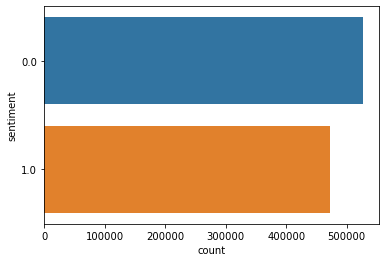

In [37]:
# dataset looks fairly balanced
sns.countplot(data = text_data, y = 'sentiment')

<AxesSubplot:xlabel='Date'>

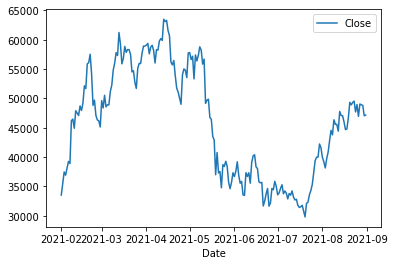

In [38]:
# price of bitcoin from feb 2021 to sept 2021
price_df.plot(x='Date')

72

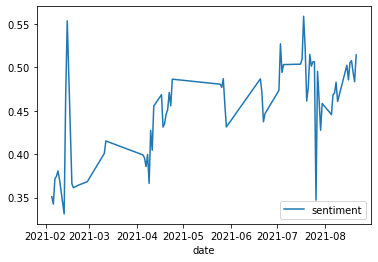

In [39]:
# percent of positive tweets per day
grouped = text_data[['date', 'sentiment']].groupby('date').mean()
grouped.plot()
len(grouped) # only 72 observations (unique days with tweets)

<AxesSubplot:xlabel='date'>

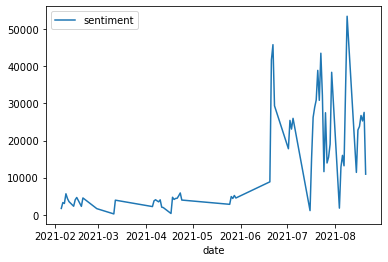

In [40]:
# count of tweets per day

count = text_data[['date', 'sentiment']].groupby('date').count()
count.plot() # seems like activity spikes in the summer

In [94]:
def visualize_top_10(freq_dist, title):
    
    '''
    Function to visualize the top 10 most common words
    '''

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

In [ ]:
# top 10 word freq for all tweets
sample_freq_dist = FreqDist(text_data["text_without_stopwords"].explode())
visualize_top_10(sample_freq_dist, "Top 10 Word Frequency")

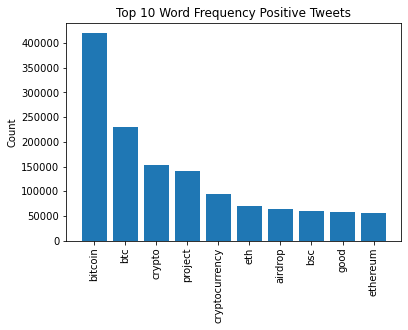

In [239]:
# top 10 word freq for positive tweets  
sample_freq_dist = FreqDist(text_data["text_without_stopwords"][text_data['sentiment']==1].explode())
visualize_top_10(sample_freq_dist, "Top 10 Word Frequency Positive Tweets")

In [ ]:
# top 10 word freq for negative tweets  
sample_freq_dist = FreqDist(text_data["text_without_stopwords"][text_data['sentiment']==0].explode())
visualize_top_10(sample_freq_dist, "Top 10 Word Frequency Positive Tweets")

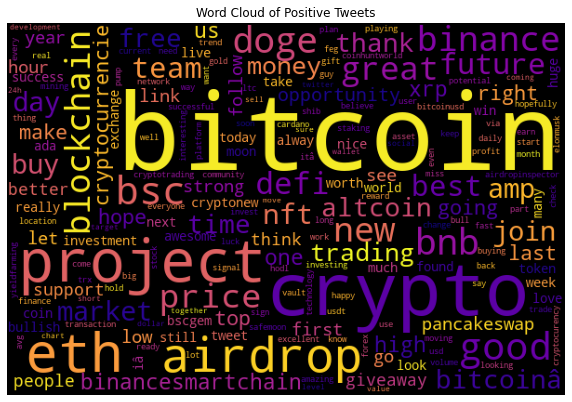

In [48]:
# word cloud for positive sentiment tweets
wordcloud = WordCloud(max_words = 200, stopwords = None, collocations = False, width = 600, height = 400, 
                       background_color = 'black', colormap = 'plasma') #Make wordcloud
wordcloud.generate(",".join(text_data["text_without_stopwords"][text_data['sentiment']==1].explode())) 
                    #Generates wordcloud from input list

plt.figure(figsize = (10, 10), facecolor = None) #set figure size
plt.imshow(wordcloud) #shows wordcloud
plt.axis('off') #sets axis
plt.title('Word Cloud of Positive Tweets'); #plot title

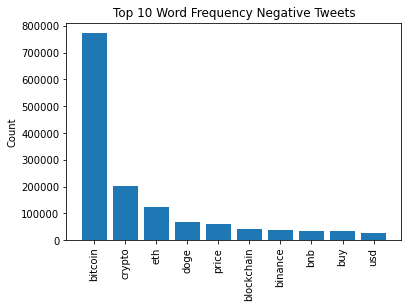

In [95]:
# top 10 word freq for positive tweets  
sample_freq_dist = FreqDist(text_data["text_without_stopwords"][text_data['sentiment']==0].explode())
visualize_top_10(sample_freq_dist, "Top 10 Word Frequency Negative Tweets")

In [96]:
wordcloud = WordCloud(max_words = 200, stopwords = None, collocations = False, width = 600, height = 400, 
                       background_color = 'black', colormap = 'plasma') #Make wordcloud
wordcloud.generate(",".join(text_data["text_without_stopwords"][text_data['sentiment']==0].explode())) 
                    #Generates wordcloud from input list

plt.figure(figsize = (10, 10), facecolor = None) #set figure size
plt.imshow(wordcloud) #shows wordcloud
plt.axis('off') #sets axis
plt.title('Word Cloud of Negative Tweets'); #plot title

TypeError: sequence item 89103: expected str instance, float found

In [100]:
text_data['text_without_stopwords'][89103]

['live',
 'info',
 'forex',
 'bitcoin',
 'bitcoin',
 'video',
 'boc',
 'breaks',
 'ranks',
 'global',
 'central',
 'banks',
 'loonie',
 'soars',
 'next',
 'lt']

In [ ]:
#### NEED TO CLEAN ###

In [238]:
# most common hashtags

ListOfHashtags = text_data['hashtag'].to_list() #Converting hashtags to list
RawHashBag = ','.join(map(str, ListOfHashtags)) #Converting list to bag of words
RawHashTokens = word_tokenize(RawHashBag) #Tokenize bag of words

hashstops = (list(string.punctuation) + ['“','”','...',"''",'’','``',"'",',','#','[',']']) #New hashstops

def remove_hashstops(bag, stopwords = hashstops): #Defining new stopword removal function
    stops_removed = [word.lower() for word in bag if word.lower() not in stopwords] #Remove if in list
    return stops_removed #Return lowercase word if not in list

CleanHashTokens = remove_hashstops(RawHashTokens) #Remove hashstops from list of cleaned hashtag tokens

frequency = FreqDist(CleanHashTokens) #Setting frequency to CleanHashTokens
frequency.most_common(25) #Looking at 25 most common tokens

[('bitcoin', 794774),
 ('btc', 387515),
 ('crypto', 216500),
 ('cryptocurrency', 152141),
 ('ethereum', 104335),
 ('eth', 99088),
 ('bsc', 77311),
 ('bnb', 77038),
 ('airdrop', 75359),
 ('blockchain', 74450),
 ('binance', 71522),
 ('dogecoin', 53182),
 ('defi', 50063),
 ('doge', 46238),
 ('airdrops', 44098),
 ('xrp', 31965),
 ('cryptocurrencies', 31870),
 ('binancesmartchain', 29404),
 ('nft', 29173),
 ('bitcoinâ', 27928),
 ('cryptonews', 26363),
 ('altcoin', 25266),
 ('trading', 23302),
 ('ada', 22369),
 ('pancakeswap', 19873)]

### Preparing to Model

In [81]:
''' 
Function that stores relevant scoring metrics
'''

def return_scores(y_train, y_hat_train, y_test, y_hat_test):
    r_train = recall_score(y_train, y_hat_train)
    r_test = recall_score(y_test, y_hat_test)
         
    f1_train = f1_score(y_train, y_hat_train)
    f1_test = f1_score(y_test, y_hat_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    pr_auc = average_precision_score(y_test, y_hat_test)
    
    ac_train = accuracy_score(y_train, y_hat_train)
    ac_test = accuracy_score(y_test, y_hat_test)
    
    return r_train, r_test, f1_train, f1_test, ac_train, ac_test, roc_auc, pr_auc

In [82]:
'''
Creates a data frame with various scores for each model
'''
# column names
scores = pd.DataFrame(columns = ['recall_train', 'recall_test', 'f1_train', 
                                 'f1_test', 'accuracy_train', 'accuracy_test', 
                                 'roc_auc', 'pr_auc', 'params'])
    

def scoreTable(model, model_name, y_train, y_hat_train, y_test, y_hat_test):
    

    # storing scores
    r_train, r_test, f1_train, f1_test, ac_train, ac_test, roc_auc, pr_auc = \
    return_scores(y_train, y_hat_train, y_test, y_hat_test)
    
    # list of scores
    score_list = []
    score_list.extend((r_train, r_test, f1_train, f1_test, 
                       ac_train, ac_test, roc_auc, pr_auc, str(model)))
    
    # adding scores to score table
    scores.loc[model_name] = score_list
    return scores

### Train Test Split

In [47]:
text_data.head()

,text,date,sentiment,is_retweet,hashtag,text_tokenized,text_without_stopwords,text2
0,blue ridge bank shares halted by nyse after #b...,2021-02-10,0.0,False,[],"[blue, ridge, bank, shares, halted, by, nyse, ...","[blue, ridge, bank, shares, halted, nyse, bitc...",blue ridge bank shares halted by nyse after bi...
1,"ð today, that's this #thursday, we will do ...",2021-02-10,0.0,False,[],"[today, that, this, thursday, we, will, do, ta...","[today, thursday, take, friend, bitcoin, walle...",today that this thursday we will do take with ...
2,"guys evening, i have read this article about b...",2021-02-10,0.0,False,[],"[guys, evening, have, read, this, article, abo...","[guys, evening, read, article, bitcoin, would,...",guys evening have read this article about bitc...
3,$btc a big chance in a billion! price: \. (// ...,2021-02-10,0.0,False,[],"[bitcoin, big, chance, in, billion, price, bit...","[bitcoin, big, chance, billion, price, bitcoin...",bitcoin big chance in billion price bitcoin fx...
4,this network is secured by nodes as of today...,2021-02-10,0.0,False,[],"[this, network, is, secured, by, nodes, as, of...","[network, secured, nodes, today, soon, biggest...",this network is secured by nodes as of today s...


In [67]:
X = text_data.drop('sentiment', axis=1)
y = text_data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [68]:
print(y_train.value_counts(normalize=True)) #fairly balanced
print(y_test.value_counts(normalize=True))

0.0    0.527191
1.0    0.472809
Name: sentiment, dtype: float64
0.0    0.526648
1.0    0.473352
Name: sentiment, dtype: float64


### Models

In [69]:
tfidf = TfidfVectorizer(max_features=10)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit(X_train['text']).transform(X_train['text']) # run on non-tokenized text

# Visually inspect the 10 most common words
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,and,bitcoin,btc,crypto,for,in,is,of,the,to
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.542054,0.400337,0.518461,0.000000,0.000000,0.526409,0.000000,0.000000,0.000000
2,0.000000,0.379205,0.560128,0.000000,0.000000,0.000000,0.736519,0.000000,0.000000,0.000000
3,0.000000,0.312480,0.461567,0.000000,0.000000,0.000000,0.000000,0.663909,0.498535,0.000000
4,0.308514,0.159558,0.000000,0.000000,0.000000,0.324156,0.309905,0.339004,0.509122,0.551465
...,...,...,...,...,...,...,...,...,...,...
749980,0.431153,0.222984,0.658746,0.426558,0.000000,0.000000,0.000000,0.000000,0.000000,0.385340
749981,0.000000,0.000000,0.000000,0.000000,0.808723,0.000000,0.000000,0.000000,0.588190,0.000000
749982,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
749983,0.000000,0.000000,0.361747,0.468484,0.000000,0.000000,0.475666,0.520329,0.390719,0.000000


In [70]:
# We should still have the same number of rows
assert X_train_vectorized.shape[0] == X_train.shape[0]

# The vectorized version should have 10 columns, since we set
# max_features=10
assert X_train_vectorized.shape[1] == 10

#### Baseline

In [71]:
# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv

array([0.61998573, 0.61863237, 0.61932572, 0.62060575, 0.61970573])

#### Pipelines

##### Prepping the Vectorizers

In [72]:
# Snowball Stemmer

stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

In [ ]:
# number of sentences - do i need this? maybe we just do number of words?
#from nltk.tokenize import sent_tokenize
#X_train["num_sentences"] = X_train["text"].apply(lambda x: len(sent_tokenize(x)))

In [78]:
glove = {}
with open('data/glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [313]:
# revisit this later
X_train_tokenized = X_train['text'].map(word_tokenize)
model_wv = Word2Vec(X_train_tokenized, size=100, window=5, min_count=1, workers=4)
model_wv.train(X_train_tokenized, total_examples=model_wv.corpus_count, epochs=10)
wv = model_wv.wv

model_wv_cv = cross_val_score(model_wv, wv, y_train)
model_wv_cv

array([0.60387208, 0.60453876, 0.60488543, 0.60501877, 0.60291873])

In [79]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [77]:
X_train_tokenized = X_train['text'].map(word_tokenize)
total_vocabulary = set(word for row in X_train_tokenized for word in row)
len(total_vocabulary)
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 267670 unique tokens in the dataset.


In [ ]:
# word to vectorizer with glove
w2v_glove = W2vVectorizer(glove)

# word to vec
w2v = 

# tfidf base
tfidf = TfidfVectorizer(max_features=10)

# tfidf w/ 50 max features, stopwords removed
tdidf_50 = TfidfVectorizer(max_features=50, stop_words=stopwords_list)

# tfidf w/ 100 max features, stopwords removed
tfidf_100 = TfidfVectorizer(max_features=100,stop_words=stopwords_list)

##### Storing and Executing Pipelines

In [ ]:
rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, 
                                                       verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression())])

In [ ]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Logistic Regression', lr)]

In [ ]:
scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

#### Model Tuning

In [75]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    max_features=20,
    stop_words=stopwords_list,
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train['text'])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,airdrop,amp,binance,bitcoin,blockchain,bnb,bsc,btc,buy,crypto,cryptocurrency,defi,doge,dogecoin,eth,ethereum,get,good,price,project
0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,0.000000,0.0,0.0,0.367582,0.515910,0.0,0.00000,0.271480,0.00000,0.351583,0.418549,0.000000,0.000000,0.000000,0.000000,0.475630,0.0,0.0,0.0,0.000000
2,0.000000,0.0,0.0,0.560608,0.000000,0.0,0.00000,0.828081,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.0,0.147746,0.000000,0.0,0.00000,0.218237,0.47032,0.000000,0.000000,0.000000,0.459305,0.465175,0.368513,0.382350,0.0,0.0,0.0,0.000000
4,0.560314,0.0,0.0,0.194015,0.000000,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.613894,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.521095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749980,0.000000,0.0,0.0,0.232038,0.000000,0.0,0.00000,0.685493,0.00000,0.443878,0.528423,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
749981,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
749982,0.742301,0.0,0.0,0.128515,0.000000,0.0,0.36532,0.000000,0.00000,0.000000,0.292668,0.000000,0.000000,0.000000,0.320546,0.332582,0.0,0.0,0.0,0.000000
749983,0.000000,0.0,0.0,0.000000,0.645565,0.0,0.00000,0.339706,0.00000,0.439940,0.523735,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [76]:
# Instantiate a MultinomialNB classifier
model_1 = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
model_1_cv = cross_val_score(model_1, X_train_vectorized, y_train)
model_1_cv

array([0.63872611, 0.63721274, 0.63870611, 0.6399928 , 0.63730608])

In [ ]:
# word2vec

In [320]:
rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])

models = [('Random Forest', rf)]

scores = [(name, cross_val_score(model, X_train_tokenized, y_train, cv=2).mean()) \
          for name, model, in models]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 10.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   21.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 10.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.3s finished


In [321]:
scores

[('Random Forest', 0.7643725286649151)]

In [86]:
# prep pipeline

pipe1 = Pipeline([
    ('Vector', TfidfVectorizer(max_features=100, stop_words=stopwords_list)), 
    ('Classifier', LogisticRegression()), 
]) #Creating Logistic Regression pipeline with Tfidf vectorizer

pipe1.fit(X_train['text'], y_train)

y_hat_train = pipe1.predict(X_train['text'])
y_hat_test = pipe1.predict(X_test['text'])

display(scoreTable(pipe1, 'tdidf_lr', y_train, y_hat_train, y_test, y_hat_test))
display(cross_val_score(pipe1, X_train['text'], y_train))

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
tdidf_rf,0.671046,0.616042,0.778288,0.719609,0.819234,0.772756,0.764827,0.714645,"Pipeline(steps=[('Vector',\n T..."
tdidf_lr2,0.487118,0.489124,0.617232,0.618661,0.714348,0.714575,0.703168,0.653435,"Pipeline(steps=[('Vector',\n T..."
tdidf_lr,0.599078,0.601423,0.717772,0.719754,0.777253,0.778308,0.769358,0.727575,"Pipeline(steps=[('Vector',\n T..."


/Users/natalyadoris/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/natalyadoris/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

array([0.77848224, 0.77734221, 0.77728888, 0.77754888, 0.77743555])

In [329]:
#scoreTable(pipe1, 'tdidf_lr', y_train, y_hat_train, y_test, y_hat_test)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
tdidf_lr,0.348017,0.349082,0.464255,0.465606,0.620232,0.620698,0.606954,0.552085,"Pipeline(steps=[('Vector',\n T..."


In [85]:
pipe2 = Pipeline([
    ('Vector', TfidfVectorizer(max_features=50,stop_words=stopwords_list)), 
    ('Classifier', LogisticRegression(solver='lbfgs', C=1e12, penalty='l2')), 
]) #Creating Logistic Regression pipeline with Tfidf vectorizer

pipe2.fit(X_train['text'], y_train)

y_hat_train = pipe2.predict(X_train['text'])
y_hat_test = pipe2.predict(X_test['text'])

display(scoreTable(pipe2, 'tdidf_lr2', y_train, y_hat_train, y_test, y_hat_test))

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
tdidf_rf,0.671046,0.616042,0.778288,0.719609,0.819234,0.772756,0.764827,0.714645,"Pipeline(steps=[('Vector',\n T..."
tdidf_lr2,0.487118,0.489124,0.617232,0.618661,0.714348,0.714575,0.703168,0.653435,"Pipeline(steps=[('Vector',\n T..."


In [84]:
# 30min runtime
pipe3 = Pipeline([
    ('Vector', TfidfVectorizer(max_features=50,stop_words=stopwords_list)), 
    ('Classifier', RandomForestClassifier(n_estimators=100, verbose=True)), 
]) #Creating Logistic Regression pipeline with Tfidf vectorizer

pipe3.fit(X_train['text'], y_train)

y_hat_train = pipe3.predict(X_train['text'])
y_hat_test = pipe3.predict(X_test['text'])

display(scoreTable(pipe3, 'tdidf_rf', y_train, y_hat_train, y_test, y_hat_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 40.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   41.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.6s finished


,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
tdidf_rf,0.671046,0.616042,0.778288,0.719609,0.819234,0.772756,0.764827,0.714645,"Pipeline(steps=[('Vector',\n T..."


In [ ]:
## deal with these later - super long runtime / not sure which X_train
## to use

# random forest is likely causing long runtime

In [342]:
w2v_rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                    ('Random Forest', RandomForestClassifier(n_estimators=100, 
                                                             verbose=True))])

w2v_rf.fit(X_train_tokenized, y_train)

y_hat_train = w2v_rf.predict(X_train_tokenized)
y_hat_test = w2v_rf.predict(X_test['text2']) # do I need to tokenize??

display(scoreTable(w2v_rf, 'w2v_rf', y_train, y_hat_train, y_test, y_hat_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [340]:
w2v_lr =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                    ('Logistic Regression', LogisticRegression(solver='lbfgs', 
                                                               C=1e12, penalty='l2'))])

w2v_lr.fit(X_train_tokenized, y_train)

y_hat_train = w2v_lr.predict(X_train['text2'])
y_hat_test = w2v_lr.predict(X_test['text2'])

display(scoreTable(w2v_lr, 'w2v_lr', y_train, y_hat_train, y_test, y_hat_test))

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
tdidf_lr2,0.508835,0.510935,0.638865,0.640766,0.728009,0.728820,0.717795,0.670421,"Pipeline(steps=[('Vector',\n T..."
w2v_rf,0.000000,0.000000,0.000000,0.000000,0.527191,0.526648,0.500000,0.473352,"Pipeline(steps=[('Word2Vec Vectorizer',\n ..."
w2v_lr,0.000000,0.000000,0.000000,0.000000,0.527191,0.526648,0.500000,0.473352,"Pipeline(steps=[('Word2Vec Vectorizer',\n ..."


#### (Pretend) Final Model

0.7772528783909012
0.778308452935247


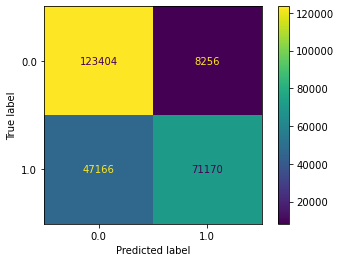

In [90]:
final_model = LogisticRegression()

tfidf = TfidfVectorizer(max_features=100, stop_words=stopwords_list)

final_X_train = tfidf.fit_transform(X_train['text'])

final_model.fit(final_X_train, y_train)
print(final_model.score(final_X_train, y_train))

# Note that we just transform, don't fit_transform
final_X_test = tfidf.transform(X_test["text"])

# Insert feature Engineering for test data
#X_test["num_sentences"] = X_test["text"].apply(lambda x: len(sent_tokenize(x)))

# if there are feature engineered columns
#X_test_vectorized_df = pd.DataFrame(X_test_vectorized.toarray(), columns=tfidf.get_feature_names())
#final_X_test = pd.concat([
#    X_test_vectorized_df, X_test[["num_sentences", "contains_price", "contains_emoticon"]]
#], axis=1)
#final_X_test

print(final_model.score(final_X_test, y_test))

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(final_model, final_X_test, y_test)


In [ ]:
# these results are same as above, proving pipeline works and there is no data leakage

In [92]:
y_hat_train_final = final_model.predict(final_X_train)
y_hat_test_final = final_model.predict(final_X_test)
display(scoreTable(final_model, 'final_model', y_train, y_hat_train_final, y_test, y_hat_test_final))

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
tdidf_rf,0.671046,0.616042,0.778288,0.719609,0.819234,0.772756,0.764827,0.714645,"Pipeline(steps=[('Vector',\n T..."
tdidf_lr2,0.487118,0.489124,0.617232,0.618661,0.714348,0.714575,0.703168,0.653435,"Pipeline(steps=[('Vector',\n T..."
tdidf_lr,0.599078,0.601423,0.717772,0.719754,0.777253,0.778308,0.769358,0.727575,"Pipeline(steps=[('Vector',\n T..."
final_model,0.599078,0.601423,0.717772,0.719754,0.777253,0.778308,0.769358,0.727575,LogisticRegression()
